# Model Use in project

SVM’s purpose in this project is similar to decision trees’ purpose, predicting whether or not a song would a user’s playlist (mine in this case). However, the difference between both models is in the input variables where I previously used audio features for the decision tree and random forest models whereas in this case, I used text data and the form of song lyrics to predict whether a song would make it to the playlist (i.e be recommended) or not. Essentially, the goal of this problem was to understand whether lyrics of songs have any predictive ability when it comes to predicting whether a user would like a certain song. 

# Additional data collection/cleaning

Similar to what was done in the Decision Tree section, additional playlists were gathered and joined with my playlist to have a final data set with a good mix of 1s and 0s, which represent in playlist and not in playlist respectively. Next a Python script was developed to gather the lyrics of all newly added songs since lyrics is the only input variable the model was to build on. Finally, since the input variable is text data count vectorizer (previously used and defined in the Data Cleaning tab) was used to transform the data into the appropriate format for modeling. 

In [45]:
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
from sklearn import tree
from IPython.display import Image
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

In [5]:
from PyPDF2 import PdfMerger

pdfs = ['/Users/anthonymoubarak/Desktop/Quiz 4-anly511.pdf', '/Users/anthonymoubarak/Desktop/Quiz4-Problem3-AnthonyMoubarak.pdf']

merger = PdfMerger()

for pdf in pdfs:
    merger.append(pdf)

merger.write("/Users/anthonymoubarak/Desktop/Quiz.pdf")
merger.close()

In [46]:
# Import the data of all playlists and their lyrics (gathered using the Lyric_scrapper.ipynb notebook)

df = pd.read_csv('/Users/anthonymoubarak/Desktop/anly-501-project-anthonymoub/501-project-website/Data/all_playlists_with_lyrics.csv')

In [47]:
# Clean the lyrics of songs (remove stop words, etc.)

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

sw_nltk = stopwords.words('english')



for i in range(len(df)):

    try:

        query = df['lyrics'][i].replace("\n" , " ")

        querywords = query.split()  

        resultwords  = [word for word in querywords if word.lower() not in sw_nltk]

        result = ' '.join(resultwords)

        df['lyrics'][i] = result
    except:
        continue

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/anthonymoubarak/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/var/folders/r_/fklxc5m54kl125_d3kkyjzp40000gn/T/ipykernel_22944/2946909150.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['lyrics'][i] = result


In [48]:
# Convert lyrics to list of strings
corpus=df["lyrics"].to_list()


In [49]:
# Initialize an index variable that stores all indexes that were removed, so that they end up being removed for the target variable
# as well

def get_index_positions(list_of_elems, element):
    ''' Returns the indexes of all occurrences of give element in
    the list- listOfElements '''
    index_pos_list = []
    index_pos = 0
    while True:
        try:
            # Search for item in list from indexPos to the end of list
            index_pos = list_of_elems.index(element, index_pos)
            # Add the index position in list
            index_pos_list.append(index_pos)
            index_pos += 1
        except ValueError as e:
            break
    return index_pos_list

indexes = get_index_positions(corpus , np.nan)


# Remove all nans from corpus

for i in np.arange(1 , corpus.count(np.nan) + 1):
    corpus.remove(np.nan)


# Initialize our target variable and drop all unwanted indexes

y = df['In_playlist'].to_list()

def delete_multiple_element(list_object, indices):
    indices = sorted(indices, reverse=True)
    for idx in indices:
        if idx < len(list_object):
            list_object.pop(idx)

delete_multiple_element(y , indexes)


In [50]:
 # INITIALIZE COUNT VECTORIZER
from sklearn.feature_extraction.text import CountVectorizer
# minDF = 0.01 means "ignore terms that appear in less than 1% of the documents". 
vectorizer=CountVectorizer(min_df=0.0001)   

# RUN COUNT VECTORIZER ON OUR COURPUS 
Xs  =  vectorizer.fit_transform(corpus)   
X=np.array(Xs.todense())

#CONVERT TO ONE-HOT VECTORS
maxs=np.max(X,axis=0)
X=np.ceil(X/maxs)



In [51]:
# Normalize data to speed up the fitting process
X = (X-X.mean())/X.std()

# SVM modelling

As discussed in the start of this section where SVM was defined and introduced, most data sets do not have linear relationships between data points which is why fitting a linear hyperplane would not always be the best-case fit for the problem. For this reason, there are multiple so-called kernels for SVM which are used in these cases where the most popular are RBF, polynomial, and sigmoid. To properly understand which one best fits my data I fit it all these four models using Python’s sklearn package and compared their training and testing accuracies.

### Linear SVM

In [52]:
# Split data intro training and testing

from sklearn.model_selection import train_test_split
test_ratio=0.2
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=test_ratio, random_state=0)

In [53]:
# Start by using a linear SVM classifier

# Set the classifier to be linear and C between 0.35-0.75. 
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import svm

#Create a svm Classifier
clf = svm.SVC(kernel='linear', C = 0.5)

#Train the model using the training sets
clf.fit(x_train, y_train)



SVC(C=0.5, kernel='linear')

In [54]:
#Predict the response for test dataset
y_pred_linear = clf.predict(x_test)

In [55]:
#Run the classifier on training data 
y_pred_linear_train = clf.predict(x_train)

In [56]:
# Get the testing accuracy 
sum(y_pred_linear == y_test)/len(y_test)

0.9108108108108108

In [57]:
# Get the training accuracy 
sum(y_pred_linear_train == y_train)/len(y_train)

0.9966216216216216

In [58]:
# Calculate the confusion matrix and classification report for the train and test data. 
report = classification_report(y_test , y_pred_linear , output_dict=True)

# Save the results in a data frame. 

report_df = pd.DataFrame(report).transpose()

# display the results data frame
report_df

,precision,recall,f1-score,support
0,0.928144,0.880682,0.903790,176.000000
1,0.896552,0.938144,0.916877,194.000000
accuracy,0.910811,0.910811,0.910811,0.910811
macro avg,0.912348,0.909413,0.910333,370.000000
weighted avg,0.911579,0.910811,0.910652,370.000000


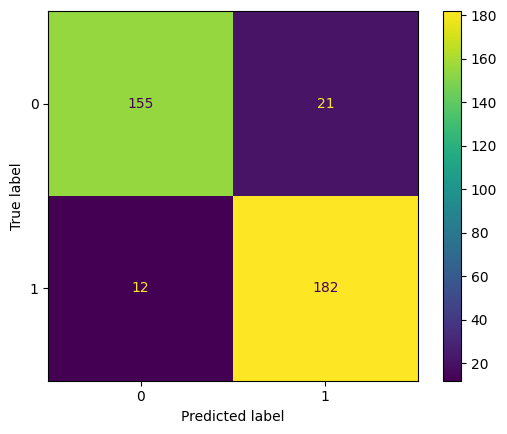

In [59]:
# Display Confusion Matrix for the test data. Remember to use the ConfusionMatrixDisplay function.
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test , y_pred_linear, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=clf.classes_)
disp.plot()

plt.show()

### Polynomial SVM

In [60]:
# Repeat the same process but for polynomial kernels 
model_poly = svm.SVC(kernel='poly', C = 0.6 , degree = 2)

#Train the model using the training sets
model_poly.fit(x_train, y_train)

#Predict the response for test dataset
y_pred_poly = model_poly.predict(x_test)

In [61]:
# Testing accuracy 
sum(y_pred_poly == y_test)/len(y_test)

0.7810810810810811

In [62]:
y_pred_poly_train = model_poly.predict(x_train)

In [63]:
# Testing accuracy 
sum(y_pred_poly_train == y_train)/len(y_train)

0.8351351351351352

In [64]:
# Calculate the confusion matrix and classification report for the train and test data. 
report_poly = classification_report(y_test , y_pred_poly , output_dict=True)

In [65]:
# Save the results in a data frame.
report_df_poly = pd.DataFrame(report_poly).transpose()

In [66]:
# display the results data frame
report_df_poly

,precision,recall,f1-score,support
0,0.935780,0.579545,0.715789,176.000000
1,0.716475,0.963918,0.821978,194.000000
accuracy,0.781081,0.781081,0.781081,0.781081
macro avg,0.826127,0.771731,0.768884,370.000000
weighted avg,0.820793,0.781081,0.771467,370.000000


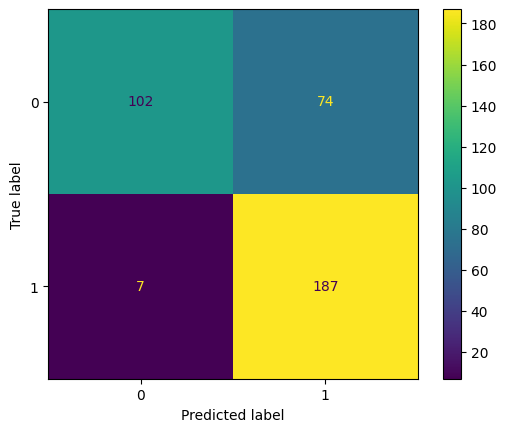

In [67]:
# Display Confusion Matrix for the test data. Remember to use the ConfusionMatrixDisplay function.

cm = confusion_matrix(y_test , y_pred_poly, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=clf.classes_)
disp.plot()

plt.show()

### RBF kernel SVM

In [68]:
# Import svc from sklearn.svm and classsification_report, confusion_matrix from sklearn.metrics.
# Fit the classfier on the training data and predict on the test data. Set the classifier to be linear and C between 0.35-0.75. 

model_rbf = svm.SVC(kernel='rbf', C = 0.6)

#Train the model using the training sets
model_rbf.fit(x_train, y_train)

#Predict the response for test dataset
y_pred_rbf = model_rbf.predict(x_test)

In [69]:
# Testing accuracy 
sum(y_pred_rbf == y_test)/len(y_test)

0.918918918918919

In [70]:
y_pred_rbf_train = model_rbf.predict(x_train)

In [71]:
# Training accuracy 
sum(y_pred_rbf_train == y_train)/len(y_train)

0.9527027027027027

In [72]:
# Calculate the confusion matrix and classification report for the train and test data. 
report_rbf = classification_report(y_test , y_pred_rbf , output_dict=True)

# Save the results in a data frame and display it.
report_df_rbf = pd.DataFrame(report_rbf).transpose()
report_df_rbf

,precision,recall,f1-score,support
0,0.910112,0.920455,0.915254,176.000000
1,0.927083,0.917526,0.922280,194.000000
accuracy,0.918919,0.918919,0.918919,0.918919
macro avg,0.918598,0.918990,0.918767,370.000000
weighted avg,0.919011,0.918919,0.918938,370.000000


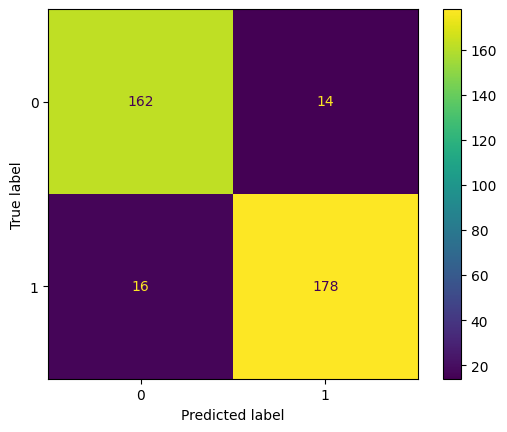

In [73]:
# Display Confusion Matrix for the test data. Remember to use the ConfusionMatrixDisplay function.

cm2 = confusion_matrix(y_test , y_pred_rbf, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm2,
                              display_labels=clf.classes_)
disp.plot()

plt.show()

### Sigmoid SVM

In [74]:
# Import svc from sklearn.svm and classsification_report, confusion_matrix from sklearn.metrics.
# Fit the classfier on the training data and predict on the test data. Set the classifier to be linear and C between 0.35-0.75. 

model_sig = svm.SVC(kernel='sigmoid', C = 0.6)

#Train the model using the training sets
model_sig.fit(x_train, y_train)

#Predict the response for test dataset
y_pred_sig = model_sig.predict(x_test)

In [75]:
# Testing accuracy 
sum(y_pred_sig == y_test)/len(y_test)

0.8891891891891892

In [76]:
y_pred_sig_train = model_sig.predict(x_train)

In [77]:
# Training accuracy
sum(y_pred_sig_train == y_train)/len(y_train)

0.9101351351351351

In [78]:
# Calculate the confusion matrix and classification report for the train and test data. 

report_sig = classification_report(y_test , y_pred_sig , output_dict=True)
report_df_sig = pd.DataFrame(report_sig).transpose()
report_df_sig

,precision,recall,f1-score,support
0,0.941176,0.818182,0.875380,176.000000
1,0.852535,0.953608,0.900243,194.000000
accuracy,0.889189,0.889189,0.889189,0.889189
macro avg,0.896856,0.885895,0.887812,370.000000
weighted avg,0.894699,0.889189,0.888416,370.000000


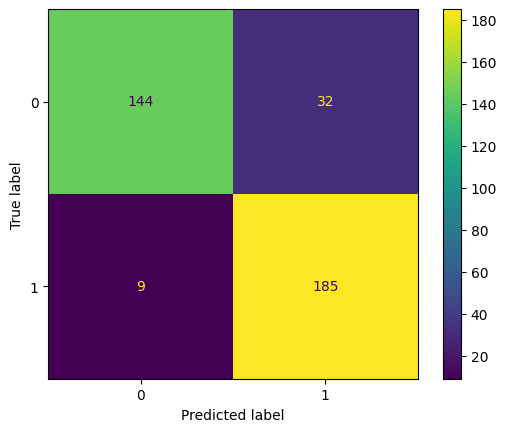

In [79]:
# Display Confusion Matrix for the test data. Remember to use the ConfusionMatrixDisplay function.

cm3 = confusion_matrix(y_test , y_pred_sig, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm3,
                              display_labels=clf.classes_)
disp.plot()

plt.show()

### Baseline classifier

In [80]:
# The baseline model is a random classifier that will be compared to all the developed models 

import random
df['predictions'] = ''

classes = [0 , 1]
for i in range(len(df)):
    df['predictions'][i] = random.choice(classes)

/var/folders/r_/fklxc5m54kl125_d3kkyjzp40000gn/T/ipykernel_22944/4045556032.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'][i] = random.choice(classes)


In [81]:
sum(df['predictions'] == df['In_playlist'])/len(df)

0.5231939163498099

# Results

In [82]:
# Comparing the models

model_accuracies_dict = {'Model': ['Linear' , 'RBF','Polynomial','Sigmoid', 'Baseline'],
'Testing accuracy (%)':[91,91,88,78,50],
'Training accuracy (%)': [99, 95, 91, 83, 50]}

model_accuracies = pd.DataFrame(model_accuracies_dict)

model_accuracies

,Model,Testing accuracy (%),Training accuracy (%)
0,Linear,91,99
1,RBF,91,95
2,Polynomial,88,91
3,Sigmoid,78,83
4,Baseline,50,50


In [83]:
tidy = model_accuracies.melt(id_vars = 'Model')
tidy

,Model,variable,value
0,Linear,Testing accuracy (%),91
1,RBF,Testing accuracy (%),91
2,Polynomial,Testing accuracy (%),88
3,Sigmoid,Testing accuracy (%),78
4,Baseline,Testing accuracy (%),50
5,Linear,Training accuracy (%),99
6,RBF,Training accuracy (%),95
7,Polynomial,Training accuracy (%),91
8,Sigmoid,Training accuracy (%),83
9,Baseline,Training accuracy (%),50


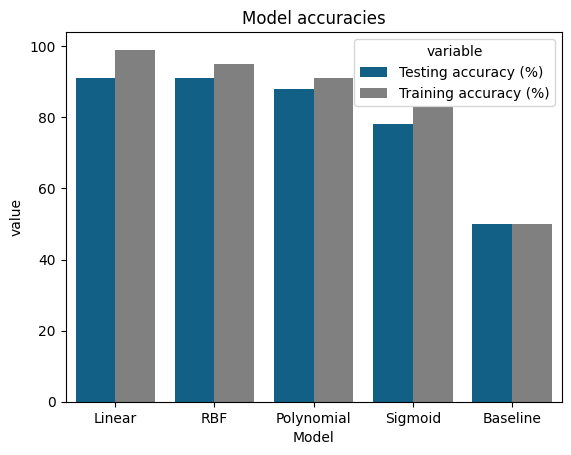

In [87]:
sns.barplot(data=tidy, x="Model", y="value" , hue='variable', palette= ['#006699','grey' , 'grey' , 'grey', 'grey',
'#006699','grey' , 'grey' , 'grey', 'grey'] ).set(title = 'Model accuracies')
plt.savefig("/Users/anthonymoubarak/Desktop/anly-501-project-anthonymoub/501-project-website/Plots/SVM_models.png")

In terms of accuracy almost all kernels perform better than the baseline model (which has an accuracy of 50%). Specifically, the RBF and linear kernels perform the best in terms of accuracy (90+% testing accuracy) but the gap between training and testing accuracy is lower for RBF kernel which indicates a lesser tendency to overfit. For this reason, I decided to choose the RBF kernel as the SVM model I want to optimize and use for classification. 

# Model selection and tuning 

As discussed in the preceding section, the RBF kernel gave the best SVM model for my project, which is why decided to use it as the model to further optimize. Optimizing SVM models usually means taking multiple kernels along with multiple hyperparameter values and seeing how the accuracies change for each possible combination. For this case I decided to stick to one kernel (RBF) and try multiple C values between 0.1 and 10.

The optimization was done using Python's GridSearch package, which fits the different options and returns the final "best" fit.In my case the best fit turned out to be for a C value equal to 10, which I later used to rebuild a new model that will act as my final SVM model. 


The optimization was done using Python's GridSearch package, which fits the different options and returns the final "best" fit.In my case the best fit turned out to be for a C value equal to 10, which I later used to rebuild a new model that will act as my final SVM model. 

In [89]:
from sklearn.model_selection import GridSearchCV

param_grid = {'C': [0.1,1, 10, 100],'kernel': ['rbf']}

grid = GridSearchCV(SVC(),param_grid,refit=True,verbose=2)

grid.fit(x_train,y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] END ..................................C=0.1, kernel=rbf; total time= 1.1min
[CV] END ..................................C=0.1, kernel=rbf; total time= 1.0min
[CV] END ..................................C=0.1, kernel=rbf; total time= 1.0min
[CV] END ..................................C=0.1, kernel=rbf; total time= 1.1min
[CV] END ..................................C=0.1, kernel=rbf; total time=  59.7s
[CV] END ....................................C=1, kernel=rbf; total time=  42.4s
[CV] END ....................................C=1, kernel=rbf; total time=  42.0s
[CV] END ....................................C=1, kernel=rbf; total time=  41.9s
[CV] END ....................................C=1, kernel=rbf; total time=  43.4s
[CV] END ....................................C=1, kernel=rbf; total time=  41.2s
[CV] END ...................................C=10, kernel=rbf; total time=  39.6s
[CV] END ...................................C=10,

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100], 'kernel': ['rbf']}, verbose=2)

In [90]:
print(grid.best_estimator_)

SVC(C=10)


In [91]:
grid_predictions = grid.predict(x_test)

In [92]:
sum(grid_predictions == y_test)/len(y_test)

0.9243243243243243

Running the final SVM model gave the best accuracy so far of 92% which does make sense considering optimization mainly focuses on improving a pre-built model. The final model’s confusion matrix can be seen below: 

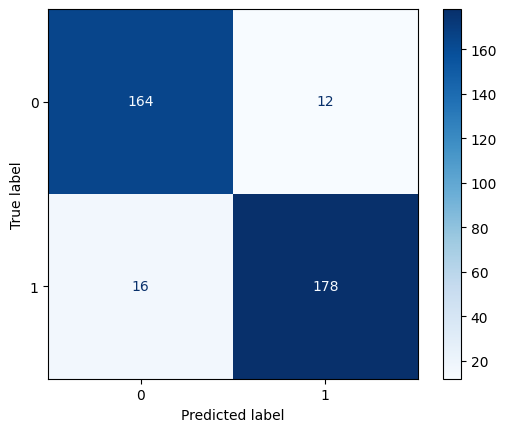

In [97]:

cm4 = confusion_matrix(y_test , grid_predictions, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm4,
                              display_labels=clf.classes_)
disp.plot(cmap = 'Blues')

plt.savefig("/Users/anthonymoubarak/Desktop/anly-501-project-anthonymoub/501-project-website/Plots/Optimized_SVM.png" ,dpi=300, bbox_inches = "tight")
plt.show()

The confusion matrix shows that for the most part the model perfectly predicts the true positives and true negatives for this problem. 

# Conclusion

All in all, SVM classification using text and lyrics data of songs proved to be a good method to predict whether a song would make a certain a user's playlist, which shows the predictive ability that lyrics of songs have. From a social perspective this indicates that most people’s music tastes could be easily differentiated by the lyrics of songs they listen to. Whether or not SVM is superior to decision trees (which was used previously) for this project is yet to be seen and could be properly understood once both of them are used in a production environment